In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install sewar

  Created wheel for sewar: filename=sewar-0.4.4-py3-none-any.whl size=10389 sha256=7053d34c05ca7c45e0a5b356095bb5b729ced39d3c89caa930f2bb216c517ac8
  Stored in directory: /root/.cache/pip/wheels/b5/00/df/f1ba40d0d44c95b0db52804e518c128d5631866b91ea1960ba
Successfully built sewar
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
## Load all the necessary packages

%matplotlib inline

import matplotlib.pyplot as plt
import skimage.transform
from skimage import data, io, filters
import numpy as np
from numpy import array
from skimage.transform import rescale, resize
from skimage.transform import resize
import os
import PIL
import pandas as pd
import imageio
import sewar


from matplotlib.pyplot import imread
import cv2

In [3]:
## Load Directory Paths

def load_path(path):
    directories = []
    if os.path.isdir(path):
        print('directory path: ', path)
        directories.append(path)
    for elem in os.listdir(path): #check for nested dir within parent dir
        if os.path.isdir(os.path.join(path,elem)):
            print('inside nested dir')
            directories = directories + load_path(os.path.join(path,elem))
            directories.append(os.path.join(path,elem))
    print('directories: ', directories)
    return directories

In [4]:
## Load Images from directory

def load_data_from_dirs(dirs, ext):
    files = []
    file_names = []
    count = 0
    res = {}
    
    for d in dirs:
        for f in os.listdir(d):
            if f.endswith(ext):
                image = cv2.imread(os.path.join(d,f))
                files.append(image)
                file_names.append(os.path.join(d,f))
                count = count + 1
                res[int(os.path.join(d,f)[40:-4])] = image
    
    print('list of files: ',len(files))
    print('list of files path: ', len(file_names), 'file path: ', file_names[0])
    print('Files Read: ',count)
    
    return res   

In [5]:
## Load Images

def load_data(directory, ext):
    files = load_data_from_dirs(load_path(directory), ext)
    return files

In [6]:
## Load HR Images from the directory
print(len('../input/tumorsrcnn/hr_tumor_imgs/'))
hr_tumor_files = load_data("../input/tumorsrcnn/hr_tumor_imgs/", ".png")

34
directory path:  ../input/tumorsrcnn/hr_tumor_imgs/
directories:  ['../input/tumorsrcnn/hr_tumor_imgs/']
list of files:  199
list of files path:  199 file path:  ../input/tumorsrcnn/hr_tumor_imgs/HRTMR_74.png
Files Read:  199


In [7]:
from collections import OrderedDict
# sorted(test_list, key = int)
srt_hr_tumor_files = OrderedDict(sorted(hr_tumor_files.items()))

In [8]:
## Convert each jpeg image to UMat format to apply polygon curve approximation in opencv2

hr_tumors = []
for i in range(1, len(srt_hr_tumor_files)):
    hr_tumors.append(cv2.cvtColor(cv2.UMat(srt_hr_tumor_files[i]), cv2.COLOR_RGB2GRAY))

In [9]:
## Function to display UMat images

def displayImages(img_arr):    
    width=8
    height=8
    rows = 3
    cols = 4
    axes=[]

    fig=plt.figure(figsize=(10,10))

    for i in range(rows * cols):
        axes.append( fig.add_subplot(rows, cols, i+1) )
        subplot_title=("Image: "+str(i+1))
        axes[-1].set_title(subplot_title)  
        plt.imshow(img_arr[i].get().astype('f'), cmap='gray')
        plt.axis('off')
    fig.tight_layout()    
    plt.show()

In [10]:
## Function to display numpy images of Tumor

def displayTumors(img_arr):    
    width=8
    height=8
    rows = 3
    cols = 4
    axes=[]

    fig=plt.figure(figsize=(10,10))

    for i in range(rows * cols):
        axes.append( fig.add_subplot(rows, cols, i+1) )
        subplot_title=("Image: "+str(i+1))
        axes[-1].set_title(subplot_title)  
        plt.imshow(img_arr[i].astype('float32').squeeze(), cmap='gray')
        plt.axis('off')
    fig.tight_layout()    
    plt.show()

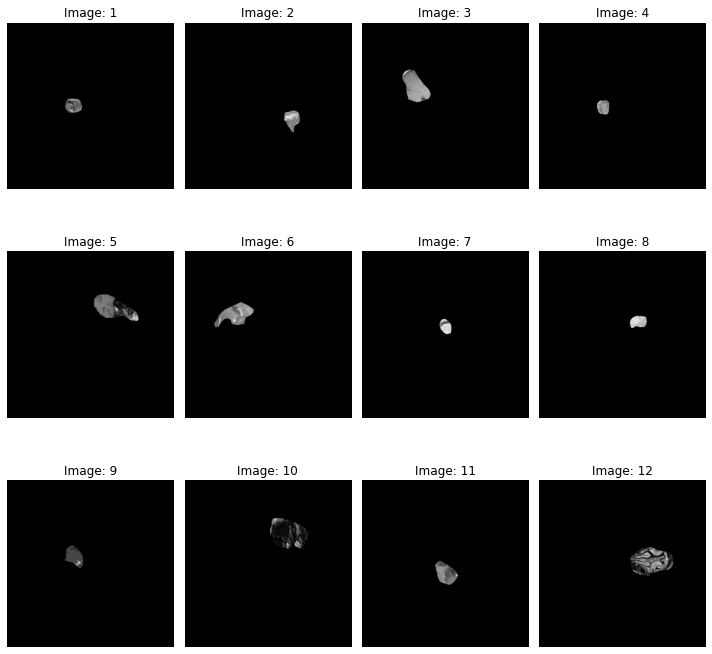

In [11]:
## Visualize few tumor images extracted using binary mask

displayImages(hr_tumors)

In [12]:
## Extract Tumor regions with the help of contours

hr_tumor_regions = []
hr_contours_regions = []
for img in hr_tumors:
    
    ret, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    ## get the biggest contour
    
    biggest_cntr = max(contours, key = cv2.contourArea)
    img_cpy = img.get().copy()
    
    ## Apply Polygon Curve approximation to extract out the tumor
    
    eps = 0.01 * cv2.arcLength(biggest_cntr, True)
    approx = cv2.approxPolyDP(biggest_cntr, eps, True)
    hr_contours_regions.append(cv2.drawContours(img_cpy, [approx],0,(255,0,0), 3))
    
    ## Bounding Rectangle
    (x,y,w,h) = cv2.boundingRect(biggest_cntr)

    ## Crop the tumor region
    
    hr_tumor_regions.append(img.get()[y:y+h, x:x+w])

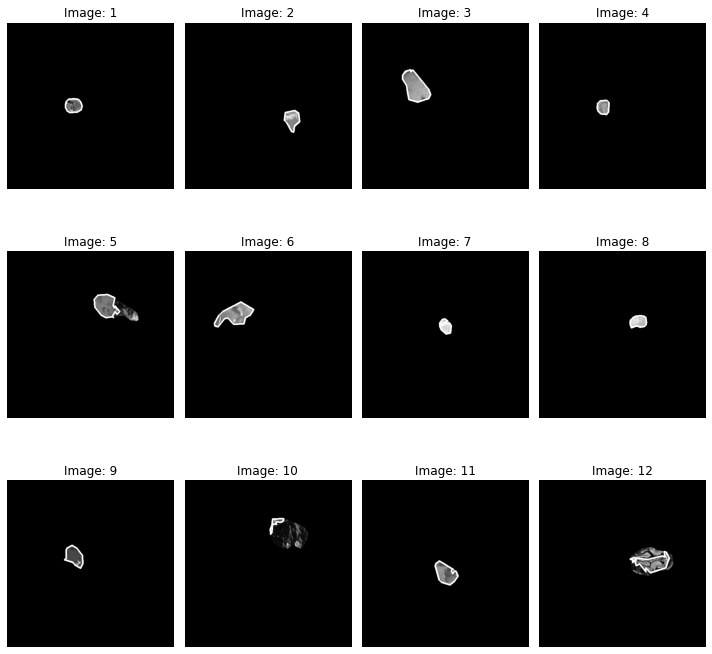

In [13]:
## Visualize tumor images with contour drawn on them

displayImages(hr_contours_regions)

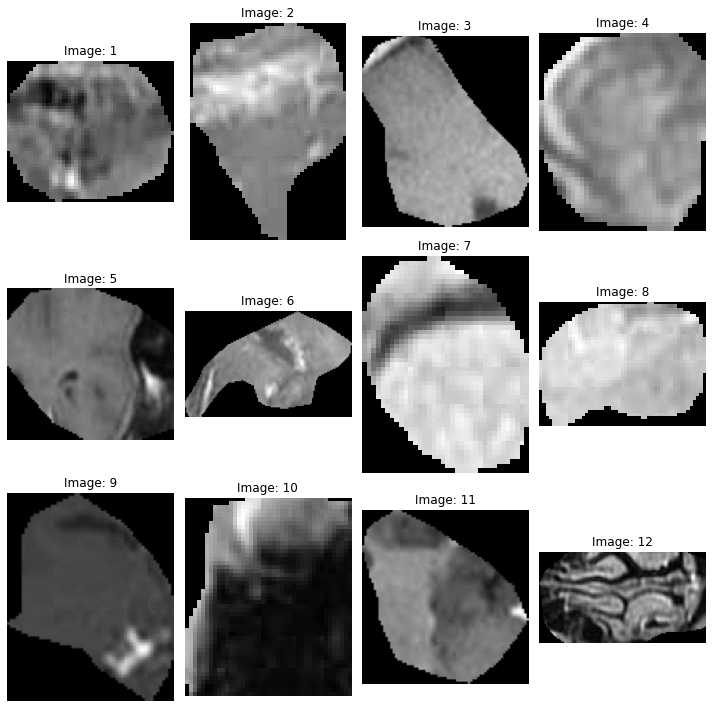

In [14]:
## Visualize extratced tumor regions

displayTumors(hr_tumor_regions)

In [15]:
## Load SR Images from the directory

sr_tumor_files = load_data("../input/tumorsrcnn/sr_tumor_imgs/", ".png")

directory path:  ../input/tumorsrcnn/sr_tumor_imgs/
directories:  ['../input/tumorsrcnn/sr_tumor_imgs/']
list of files:  199
list of files path:  199 file path:  ../input/tumorsrcnn/sr_tumor_imgs/SRTMR_130.png
Files Read:  199


In [16]:
from collections import OrderedDict
# sorted(test_list, key = int)
srt_sr_tumor_files = OrderedDict(sorted(hr_tumor_files.items()))

In [17]:
## Convert each image to UMat in order to apply 

sr_tumors = []
for i in range(1, len(srt_sr_tumor_files)):
    sr_tumors.append(cv2.cvtColor(cv2.UMat(srt_sr_tumor_files[i]), cv2.COLOR_RGB2GRAY))

### Display SR Tumor Images

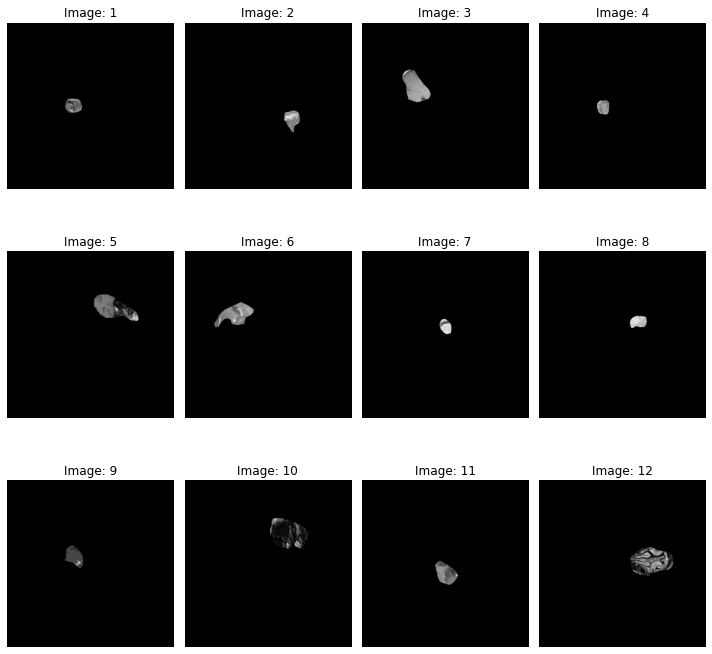

In [18]:
## Display SR Tumors

displayImages(sr_tumors)

In [19]:
def img_normal(img1, img2):
    hr_img = img1.astype(np.uint16)
    sr_img = img2.astype(np.uint16)
    hr_img = 0.2*hr_img/255.
    sr_img = 0.1*sr_img/255.
    return hr_img, sr_img

In [20]:
## Extract Tumor regions with the help of contours

sr_tumor_regions = []
sr_contours_regions = []
for img in sr_tumors:
    
    ret, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    ## get the biggest contour
    
    biggest_cntr = max(contours, key = cv2.contourArea)
    img_cpy = img.get().copy()
    
    ## Apply Polygon Curve approximation to extract out the tumor
    
    eps = 0.01 * cv2.arcLength(biggest_cntr, True)
    approx = cv2.approxPolyDP(biggest_cntr, eps, True)
    sr_contours_regions.append(cv2.drawContours(img_cpy, [approx],0,(255,0,0), 3))
    
    ## Bounding Rectangle
    (x,y,w,h) = cv2.boundingRect(biggest_cntr)

    ## Crop the tumor region
    
    sr_tumor_regions.append(img.get()[y:y+h, x:x+w])

### Display Contours on Tumor

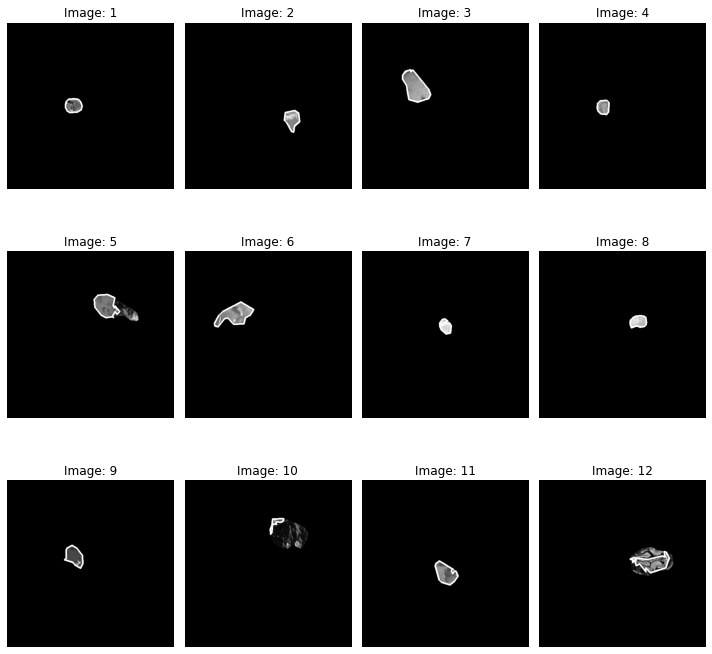

In [21]:
displayImages(sr_contours_regions)

### Display Extracted Tumor Regions

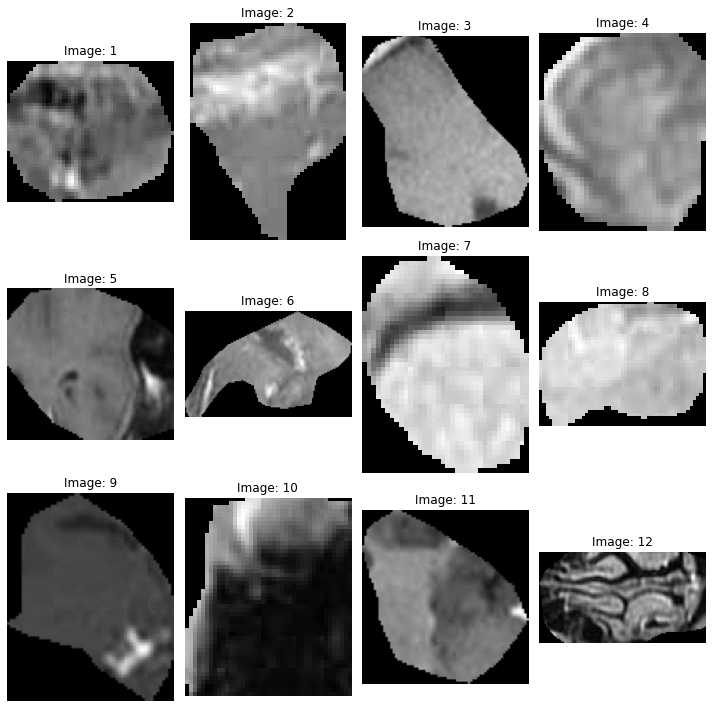

In [22]:
displayTumors(sr_tumor_regions)

In [23]:
srcnn_tumor_metric = {}
srcnn_tumor_metric["tumor"] = {}
srcnn_tumor_metric["mannwhitneyu"] = {}

### Compute SSIM parameters individually and see the output

## Defining Constants C1 and C2 and C3

### C1 = (K1,L)
### C2 = (K2,L)
### C3 = C2/2

## L is the dynamic range for pixel values [How to decide Value of L?](https://scikit-image.org/docs/dev/user_guide/data_types.html)

**Here K1 and K2 are constant values very very close to 0** 

In [24]:
C1 = (0.01 * 65535) ** 2 
C2 = (0.03 * 65535) ** 2
C3 = C2/2

In [25]:
def luminance(img1, img2):
    mu1 = img1.mean()
    mu2 = img2.mean()
    mu1_sqr = mu1 ** 2
    mu2_sqr = mu2 ** 2
    L = (2*mu1*mu2 + C1) / (2*(mu1_sqr + mu2_sqr) + C1)
    return L

In [26]:
def contrast(img1, img2):
    sigma1 = img1.std()
    sigma2 = img2.std()
    sigma1_sqr = sigma1 ** 2
    sigma2_sqr = sigma2 ** 2
    C = (2*sigma1*sigma2 + C2) / (2*(sigma1_sqr + sigma2_sqr) + C2)
    return C

In [27]:
def structure(img1, img2):
    C3 = C2/2
    sigma1 = img1.std()
    sigma2 = img2.std()
    sigma12 = np.cov(img1, img2)[0,1]
    S = (sigma12 + C3) / (2*sigma1*sigma2 + C3) 
    return S

In [28]:
def compute_ssim(sr_img, hr_img):
    
    sr_img = sr_img.astype(np.uint16)
    hr_img = hr_img.astype(np.uint16)
    
    img1 = np.array(list(filter(lambda pixel : pixel !=0, sr_img.flatten())))
    img2 = np.array(list(filter(lambda pixel : pixel !=0, hr_img.flatten())))
    
    ## Computing Luminance Comparison Function
    
    L = luminance(img1, img2)
    
    ## Computing Contrast Comparison Function
    
    C = contrast(img1, img2)
    
    ## Computing Structure Comparison Function
    
    S = structure(img1, img2)
    
    ## defining alpha, beta, gamma
    
    alpha, beta, gamma = 1, 1, 1

    ssim = (L ** alpha) * (C ** beta) ** (S ** gamma)
    
    return ssim

In [29]:
from skimage.metrics import structural_similarity as ssim

In [30]:
## Compute SSIM for single image
compute_ssim(sr_tumor_regions[22],hr_tumor_regions[22])

0.8997465374039191

In [31]:
ssim_arr = []
for sr_img, hr_img in zip(sr_tumor_regions,hr_tumor_regions):
    ssim_arr.append(compute_ssim(sr_img, hr_img))
    
## Display Results for starting 10 images

print(ssim_arr[:10])

[0.9500235229331034, 0.910997427944345, 0.9128005683808706, 0.9153142651915388, 0.9587224978891522, 0.9215536023877412, 0.8717596564653635, 0.861933732786016, 0.9765488363464584, 0.9890633893636767]


In [32]:
ssim_mean, ssim_std = np.mean(ssim_arr), np.std(ssim_arr)
srcnn_tumor_metric["tumor"]["ssim"] = ssim_arr
print("mean: ", ssim_mean, " std: ", ssim_std)

mean:  0.9178026198340886  std:  0.04281152966754949


## Universal Quality Index (UQI)

### It is special case of SSIM when C1=0 and C2=0

**NOTE: It produces unstable results when either (mu1_srq + mu2_srq) or (sigma1_sqr + sigma2_sqr) is close to 0**

In [ ]:
# def displayResults(img_arr1, img_arr2,ssim_arr, metric, dim=(1, 3), figsize=(15, 5)):    
#     width=8
#     height=8
#     rows = 5
#     cols = 5
#     axes=[]

#     fig=plt.figure(figsize=(10,10))

#     for i in range(rows * cols):
#         plt.figure(figsize=figsize)

#         plt.subplot(dim[0], dim[1], 1)
#         plt.imshow(img_arr1[i].squeeze(), interpolation='nearest', cmap='gray')
#         plt.title(f"Super Resolution Image Tumor {i+1}")
#         plt.axis('off')

#         plt.subplot(dim[0], dim[1], 2)
#         plt.imshow(img_arr2[i].squeeze(), interpolation='nearest', cmap='gray')
#         plt.title(f"Origial Image Tumor {i+1}")
#         plt.axis('off')
        
#         plt.subplot(dim[0], dim[1], 3)
#         plt.text(0.5, 0.5,f"{metric} {ssim_arr[i]}")
#         plt.axis('off')
        
#     fig.tight_layout()    
#     plt.show()

## Display SSIM Results for starting 10 Images

In [ ]:
# displayResults(sr_tumor_regions, hr_tumor_regions, ssim_arr, "SSIM")

## Mean Absolute Error

In [33]:
def MAE(true_img, pred_img):
    
    hr_img, sr_img = img_normal(true_img, pred_img)
    
    img1 = np.array(list(filter(lambda pixel : pixel !=0., sr_img.flatten())))
    img2 = np.array(list(filter(lambda pixel : pixel !=0., hr_img.flatten())))
    metric = (np.sum(np.absolute(np.subtract(img1, img2)))) / len(img1)
    return metric

In [34]:
MAE(hr_tumor_regions[0], sr_tumor_regions[0])

0.04259240355578239

In [35]:
mae_arr=[]
for img1, img2 in zip(hr_tumor_regions, sr_tumor_regions):
    mae_arr.append(MAE(img1, img2))
print(mae_arr[:10])

[0.04259240355578239, 0.05961841645661635, 0.05894078197597967, 0.05789633024927143, 0.03823322658092719, 0.05530336473322157, 0.07504704332325816, 0.07929767117202868, 0.028331973296651203, 0.018081407199054256]


In [36]:
mae_mean, mae_std = np.mean(mae_arr), np.std(mae_arr)
srcnn_tumor_metric["tumor"]["mae"] = mae_arr
print("mean: ", mae_mean, " std: ", mae_std)

mean:  0.05568463242214422  std:  0.018435602342514727


## Mean Percentage Error

In [37]:
def MPE(true_img, pred_img):
    
    hr_img, sr_img = img_normal(true_img, pred_img)
    
    img1 = np.array(list(filter(lambda pixel : pixel !=0, hr_img.flatten())))
    img2 = np.array(list(filter(lambda pixel : pixel !=0., sr_img.flatten())))
    metric = np.sum((img1 - img2)) / len(img1)
    return metric * 100

In [38]:
MPE(hr_tumor_regions[0], sr_tumor_regions[0])

4.259240355578239

In [39]:
mpe_arr=[]
for img1, img2 in zip(hr_tumor_regions, sr_tumor_regions):
    mpe_arr.append(MPE(img1, img2))
print(mpe_arr[:10])

[4.259240355578239, 5.961841645661635, 5.894078197597967, 5.789633024927143, 3.823322658092719, 5.530336473322157, 7.504704332325816, 7.929767117202868, 2.8331973296651203, 1.8081407199054256]


In [40]:
mpe_mean, mpe_std = np.mean(mpe_arr), np.std(mpe_arr)
srcnn_tumor_metric["tumor"]["mpe"] = mpe_arr
print("mean: ", mpe_mean, " std: ", mpe_std)

mean:  5.5684632422144205  std:  1.8435602342514728


In [41]:
def hr_normal(img):
    hr_img = img.astype(np.uint16)
    hr_img = 0.2*hr_img/255.
    return hr_img

In [42]:
def sr_normal(img):
    sr_img = img.astype(np.uint16)
    sr_img = 0.1*sr_img/255.
    return sr_img

In [43]:
n_hr_tumor_regions = []
for img in hr_tumor_regions:
    n_hr_tumor_regions.append(hr_normal(img))
    
n_sr_tumor_regions = []
for img in sr_tumor_regions:
    n_sr_tumor_regions.append(sr_normal(img))

### Mean Square Error (MSE)

In [44]:
ans = sewar.full_ref.mse(n_hr_tumor_regions[9], n_sr_tumor_regions[9])
print(ans, type(ans))

0.000638744146024423 <class 'numpy.float64'>


In [45]:
mse_arr = []
for img1, img2 in zip(n_hr_tumor_regions, n_sr_tumor_regions):
    mse_arr.append(sewar.full_ref.mse(img1, img2))
    
## Display Results for starting 10 images

print(mse_arr[:10])

[0.0015836936035897977, 0.0023880324444673982, 0.00220167813440454, 0.002940407063244434, 0.001349922160199123, 0.0016529296676169622, 0.004484954686459018, 0.005060037240578662, 0.0005520157754230925, 0.000638744146024423]


In [46]:
mse_mean, mse_std = np.mean(mse_arr), np.std(mse_arr)
srcnn_tumor_metric["tumor"]["mse"] = mse_arr
print("mean: ", mse_mean, " std: ", mse_std)

mean:  0.002691187390178039  std:  0.00161518902381374


### Root Mean Square Error (RMSE)

In [47]:
ans = sewar.full_ref.rmse(n_hr_tumor_regions[9], n_sr_tumor_regions[9])
print(ans, type(ans))

0.02527338809943026 <class 'numpy.float64'>


In [48]:
rmse_arr = []
for img1, img2 in zip(n_hr_tumor_regions, n_sr_tumor_regions):
    rmse_arr.append(sewar.full_ref.rmse(img1, img2))
    
## Display Results for starting 10 images

print(rmse_arr[:10])

[0.03979564804837079, 0.04886749885626845, 0.046922043161019104, 0.0542255204054736, 0.03674128686095689, 0.04065623774547963, 0.06696980428864205, 0.07113393873938559, 0.023495015969841188, 0.02527338809943026]


In [49]:
rmse_mean, rmse_std = np.mean(rmse_arr), np.std(rmse_arr)
srcnn_tumor_metric["tumor"]["rmse"] = rmse_arr
print("mean: ", rmse_mean, " std: ", rmse_std)

mean:  0.04947006434349513  std:  0.015617302072653003


## PSNR

In [50]:
from skimage.metrics import peak_signal_noise_ratio as psnr

In [51]:
ans = psnr(n_hr_tumor_regions[4], n_sr_tumor_regions[4])
print(ans, type(ans))

28.696912732610123 <class 'numpy.float64'>


In [52]:
psnr_arr = []
for img1, img2 in zip(n_hr_tumor_regions, n_sr_tumor_regions):
    psnr_arr.append(psnr(img1, img2))
    
## Display Results for starting 10 images
print(psnr_arr[:10])

[28.00328837356076, 26.21959777057978, 26.5724617068177, 25.315925426887272, 28.696912732610123, 27.817456253249162, 23.482419404727807, 22.958462868522368, 32.580485108916314, 31.946730670700532]


In [53]:
psnr_mean, psnr_std = np.mean(psnr_arr), np.std(psnr_arr)
srcnn_tumor_metric["tumor"]["psnr"] = psnr_arr
print("mean: ", psnr_mean, " std: ", psnr_std)

mean:  26.57141241390908  std:  2.876159394414008


## Multi-Scale Structural Similarity Index (MS-SSIM)

In [54]:
ans = sewar.full_ref.msssim(hr_tumor_regions[2].astype(np.uint16), sr_tumor_regions[2].astype(np.uint16)).real
print(ans, type(ans))

1.0 <class 'numpy.float64'>


In [55]:
msssim_arr = []
for img1, img2 in zip(hr_tumor_regions, sr_tumor_regions):
#     msssim_arr.append(sewar.full_ref.scc(img1, img2))
    try:
        msssim_arr.append(sewar.full_ref.msssim(img1.astype(np.uint16), img2.astype(np.uint16)).real)
    except:
        continue
## Display Results for starting 10 images
print(msssim_arr[:10])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [56]:
msssim_mean, msssim_std = np.mean(msssim_arr), np.std(msssim_arr)
srcnn_tumor_metric["tumor"]["msssim"] = msssim_arr
print("mean: ", msssim_mean,  " std: ", msssim_std)

mean:  1.0  std:  0.0


### Spatial Corelation Coefficient (SCC)

In [57]:
ans = sewar.full_ref.scc(n_hr_tumor_regions[3], n_sr_tumor_regions[3])
print(ans, type(ans))

0.9944717444717445 <class 'numpy.float64'>


In [58]:
scc_arr = []
for img1, img2 in zip(n_hr_tumor_regions, n_sr_tumor_regions):
    scc_arr.append(sewar.full_ref.scc(img1, img2))
    
## Display Results for starting 10 images

print(scc_arr[:10])

[0.986013986013986, 0.8504353233830846, 0.7664367816091954, 0.9944717444717445, 0.9272151898734177, 0.7067725662766985, 0.9592198581560284, 0.9881320949432405, 0.8299975290338523, 0.9876190476190476]


In [59]:
scc_mean, scc_std = np.mean(scc_arr), np.std(scc_arr)
srcnn_tumor_metric["tumor"]["scc"] = scc_arr
print("mean: ", scc_mean,  " std: ", scc_std)

mean:  0.898584774307431  std:  0.09160707706607493


### Pixel Based Visual Information Fidelity (vif-p)

In [60]:
ans = sewar.full_ref.vifp(n_hr_tumor_regions[5], n_sr_tumor_regions[5])
print(ans, type(ans))

0.2500864978681751 <class 'numpy.float64'>


In [61]:
vifp_arr = []
for img1, img2 in zip(n_hr_tumor_regions, n_sr_tumor_regions):
#     vifp_arr.append(sewar.full_ref.scc(img1, img2))
    try:
        vifp_arr.append(sewar.full_ref.vifp(img1, img2))
    except:
        continue
    
## Display Results for starting 10 images

print(vifp_arr[:10])

[0.2500352778896973, 0.2500716411860803, 0.25010421187288273, 0.25002546157981487, 0.2500570683695798, 0.2500864978681751, 0.25012524037585204, 0.250049103556759, 0.25003538822687155, 0.2500575088075578]


In [62]:
vifp_mean, vifp_std = np.mean(vifp_arr), np.std(vifp_arr)
srcnn_tumor_metric["tumor"]["vifp"] = vifp_arr
print("mean: ", vifp_mean,  " std: ", vifp_std)

mean:  0.25009361658212337  std:  5.302012474177011e-05


In [ ]:
# os.mkdir('./tumor')

In [ ]:
# os.mkdir('./tumor/error_barplot')
# os.mkdir('./tumor/scatter')
# os.mkdir('./tumor/regression')

In [ ]:
# ## Define error bar plot function

# def error_barplot(error_arr,title='', file_name=''):
    
#     # Calculate the average
#     error_mean = np.mean(error_arr)
    
#     # Calculate the standard deviation
#     error_std = np.std(error_arr)

#     # Define labels, positions, bar heights and error bar heights
#     labels = ['For 200 Images']
#     x_pos = np.arange(len(labels))
#     CTEs = [error_mean]
#     error = [error_std]
    
#     # Build the plot
#     fig, ax = plt.subplots(figsize=(5,5))
#     ax.bar(x_pos, CTEs,yerr=error,align='center',alpha=0.5,ecolor='black',capsize=10)
# #     ax.set_ylabel('Mean Percentage Error')
#     ax.set_xticks(x_pos)
#     ax.set_xticklabels(labels)
#     ax.set_title(title)
#     ax.yaxis.grid(True)
    
#     plt.savefig(f"./tumor/error_barplot/{file_name}.png")

#     # Save the figure and show
#     plt.tight_layout()
#     # plt.savefig('bar_plot_with_error_bars.png')
#     plt.show()

In [ ]:
# error_barplot(mae_arr,title='Mean Absolute Error (MAE)', file_name='mae_barplot')

In [ ]:
# error_barplot(mpe_arr,title='Mean Percentage Error (MPE)', file_name='mpe_barplot')

In [ ]:
# error_barplot(mse_arr,title='Mean Square Error (MSE)', file_name='mse_barplot')

In [ ]:
# error_barplot(rmse_arr,title='Root Mean Square Error (RMSE)', file_name='rmse_barplot')

In [ ]:
# error_barplot(psnr_arr,title='Peak Signal to Noise Ratio (PSNR)', file_name='psnr_barplot')

In [ ]:
# error_barplot(ssim_arr,title='Structural Similarity Index (SSIM)', file_name='ssim_barplot')

In [ ]:
# error_barplot(scc_arr,title='Spatial Corelation Coefficient (SCC)', file_name='scc_barplot')

In [ ]:
# error_barplot(vifp_arr,title='Pixel Based Visual Information Fidelity (vif-p)', file_name='vifp_barplot')

## Scatter Plot for MAE, MPE, MSE, RMSE, PSNR, SSIM, MS-SSIM, SCC and VIF-P

In [ ]:
# import seaborn as sns
# sns.set_theme(style="whitegrid")
# sns.set(rc={'figure.figsize':(8,8)})

In [ ]:
# metric_dict = {'Images': [i for i in range(1,199)],
#             'MAE' : mae_arr,
#             'MPE' : mpe_arr,
#             'MSE' : mse_arr,
#             'RMSE' : rmse_arr,
#             'PSNR' : psnr_arr,
#             'SSIM' : ssim_arr,
#             'SCC' : scc_arr,
#             'VIFP' : vifp_arr
#          }
# metric_df = pd.DataFrame(metric_dict)

In [ ]:
# def getScatterPlot(y_val,df,title='', file_name=''):
    
#     sns_plt = sns.scatterplot(x=metric_df.Images, y=y_val, data=df, linewidth=2.5).set_title(title)
#     sns_fig = sns_plt.get_figure()
#     sns_fig.savefig(f"./tumor/scatter/{file_name}.png")

In [ ]:
# def RegPlot(y_val,df,title='', file_name=''):
    
#     sns_plt = sns.regplot(x=metric_df.Images, y=y_val, data=df).set_title(title)
#     sns_fig = sns_plt.get_figure()
#     sns_fig.savefig(f"./tumor/regression/{file_name}.png")

In [ ]:
# getScatterPlot(metric_df.MAE, metric_df, 'Mean Absolute Error', 'mae_scatter')

In [ ]:
# getScatterPlot(metric_df.MPE, metric_df, title='Mean Percentage Error', file_name='mpe_scatter')

In [ ]:
# getScatterPlot(metric_df.MSE, metric_df, title='Mean Square Error', file_name='mse_scatter')

In [ ]:
# getScatterPlot(metric_df.RMSE, metric_df, title='Root Mean Square Error', file_name='rmse_scatter')

In [ ]:
# getScatterPlot(metric_df.PSNR, metric_df, title='Peak Signal to Noise Ratio', file_name='psnr_scatter')

In [ ]:
# getScatterPlot(metric_df.SSIM, metric_df, title='Structure Similarity Index', file_name='ssim_scatter')

In [ ]:
# getScatterPlot(metric_df.SCC, metric_df, title='Spatial Corelation Coefficient', file_name='scc_scatter')

In [ ]:
# getScatterPlot(metric_df.VIFP, metric_df, title='Pixel Based Visual Information Fidelity', file_name='vifp_scatter')

## Regression Plot for MAE, MPE, MSE, RMSE, PSNR, SSIM, MS-SSIM, SCC and VIF-P

In [ ]:
# RegPlot(metric_df.MAE, metric_df, 'Mean Absolute Error', 'mae_scatter')

In [ ]:
# RegPlot(metric_df.MPE, metric_df, title='Mean Percentage Error', file_name='mpe_scatter')

In [ ]:
# RegPlot(metric_df.MSE, metric_df, title='Mean Square Error', file_name='mse_scatter')

In [ ]:
# RegPlot(metric_df.RMSE, metric_df, title='Root Mean Square Error', file_name='rmse_scatter')

In [ ]:
# RegPlot(metric_df.PSNR, metric_df, title='Peak Signal to Noise Ratio', file_name='psnr_scatter')

In [ ]:
# RegPlot(metric_df.SSIM, metric_df, title='Structure Similarity Index', file_name='ssim_scatter')

In [ ]:
# RegPlot(metric_df.SCC, metric_df, title='Spatial Corelation Coefficient', file_name='scc_scatter')

In [ ]:
# RegPlot(metric_df.VIFP, metric_df, title='Pixel Based Visual Information Fidelity', file_name='vifp_scatter')

In [63]:
import pickle

with open('./srcnn_tumor_pickle.pkl', 'wb') as f:
    pickle.dump(srcnn_tumor_metric, f)

In [64]:
%%!

zip srcnn_tumor_metric.zip ./srcnn_tumor_pickle.pkl

['  adding: srcnn_tumor_pickle.pkl (deflated 55%)']